# Parking Pain Metric

This notebook defines a custom metric to measure how “painful” it is to park in different Pittsburgh neighborhoods.

We define **parking pain** based on:
- **Number of parking meters** (more meters = more competition = more pain)
- **Average hourly parking rate** (higher = more cost = more pain)

We’ll compute:
- A `pain_raw` score (higher = worse parking experience)
- A `parking_score` (normalized so higher = better parking experience)

This will help identify which neighborhoods are the easiest or hardest to park in.


In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

## Load and Clean Parking Meter Data

We begin by loading the Pittsburgh parking meter dataset. We remove any entries with missing location or rate data, then extract the numeric hourly rate from strings like "$1 per hour".


In [31]:
df = pd.read_csv("../data/raw/LOCAL_PARKING_CSV_PATH.csv")
df = df.dropna(subset=["longitude", "latitude", "rate"])
df["rate"] = df["rate"].astype(str).str.extract(r"([0-9]*\.?[0-9]+)")
df["rate"] = pd.to_numeric(df["rate"], errors="coerce")
df = df.dropna(subset=["rate"])

## Convert to GeoDataFrame

We create geometry points from each meter's coordinates and convert the DataFrame into a GeoDataFrame.


In [32]:
geometry = [Point(xy) for xy in zip(df["longitude"], df["latitude"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")


## Assign Parking Meters to Neighborhoods & Build the Parking Pain Metric

To determine which Pittsburgh neighborhood each parking meter belongs to, we load the official city neighborhood boundary shapefile and ensure it uses the same coordinate reference system as our parking meter GeoDataFrame. A spatial join is then performed to attach each meter point to the neighborhood polygon that contains it.
After the join, we aggregate the data at the neighborhood level by computing:
 - meter_count: total number of parking meters in each neighborhood
 - avg_rate: the mean hourly parking meter rate for each neighborhood

These two components form the basis of our parking difficulty metric. We calculate a raw pain score as: pain_raw = meter_count x avg_rate
However, because neighborhoods often have similar parking rates and meter densities, the raw pain values tend to cluster tightly. To make the differences more interpretable, we apply a logarithmic transformation: pain_log = log(1+pain_raw)
This transformation spreads out the compressed values while maintaining the original ranking.
Finally, we normalize the transformed values to a 0–1 range and invert them so that:
 - Higher parking_score = easier parking
 - Lower parking_score = more painful parking

This produces a clean, interpretable metric that highlights meaningful differences between neighborhoods.

In [34]:
# --- Load Pittsburgh Neighborhood Boundaries ---
neighborhoods = gpd.read_file("../data/raw/Neighborhoods_.shp")
neighborhoods = neighborhoods.to_crs(gdf.crs)
joined = gpd.sjoin(gdf, neighborhoods, how="left", predicate="within")
joined[['rate', 'geometry', 'hood']].head()
# --- Grouping and Aggregation ---
meter_counts = joined.groupby('hood').size().reset_index(name='meter_count')
avg_rates = joined.groupby('hood')['rate'].mean().reset_index(name='avg_rate')
parking_df = pd.merge(meter_counts, avg_rates, on='hood')
# --- Pain score calculation ---
parking_df['pain_raw'] = parking_df['meter_count'] * parking_df['avg_rate']
parking_df['pain_log'] = np.log1p(parking_df['pain_raw'])  # log(1 + x)
parking_df['pain_norm'] = (
    (parking_df['pain_log'] - parking_df['pain_log'].min()) /
    (parking_df['pain_log'].max() - parking_df['pain_log'].min())
)
parking_df['parking_score'] = 1 - parking_df['pain_norm']

## Spatial Join: Match Parking Meters to Neighborhoods

Next, we perform a spatial join to associate each parking meter with the neighborhood it falls within.


In [35]:
joined = gpd.sjoin(gdf, neighborhoods, how="left", predicate="within")

## Calculate Meter Count and Average Rate per Neighborhood

We compute two key values for each neighborhood:
- Total number of meters (`meter_count`)
- Average hourly parking rate (`avg_rate`)


In [36]:
meter_count = joined.groupby("hood").size().reset_index(name="meter_count")
avg_rate = joined.groupby("hood")["rate"].mean().reset_index(name="avg_rate")
merged = pd.merge(meter_count, avg_rate, on="hood")

## Compute the Parking Pain Score

With meter counts and average rates aggregated for each neighborhood, we now compute the parking pain metric. We first calculate a raw pain value based on the idea that neighborhoods with more meters and higher hourly rates are generally harder to park in. This raw score is then normalized to a 0–1 range and inverted so that:
 - Higher parking_score means easier parking,
 - Lower parking_score means more parking difficulty.

Finally, we sort neighborhoods by parking_score to prepare the results for visualization.

In [42]:
merged["pain_raw"] = merged["meter_count"] * merged["avg_rate"]
merged["pain_norm"] = (
    (merged["pain_raw"] - merged["pain_raw"].min()) /
    (merged["pain_raw"].max() - merged["pain_raw"].min())
)
merged["parking_score"] = 1 - merged["pain_norm"]
final_df = merged.sort_values(by="parking_score", ascending=False)

## Top 10 Neighborhoods (Easiest to Park In)

We visualize the 10 neighborhoods with the **highest** parking scores (least painful to park in).


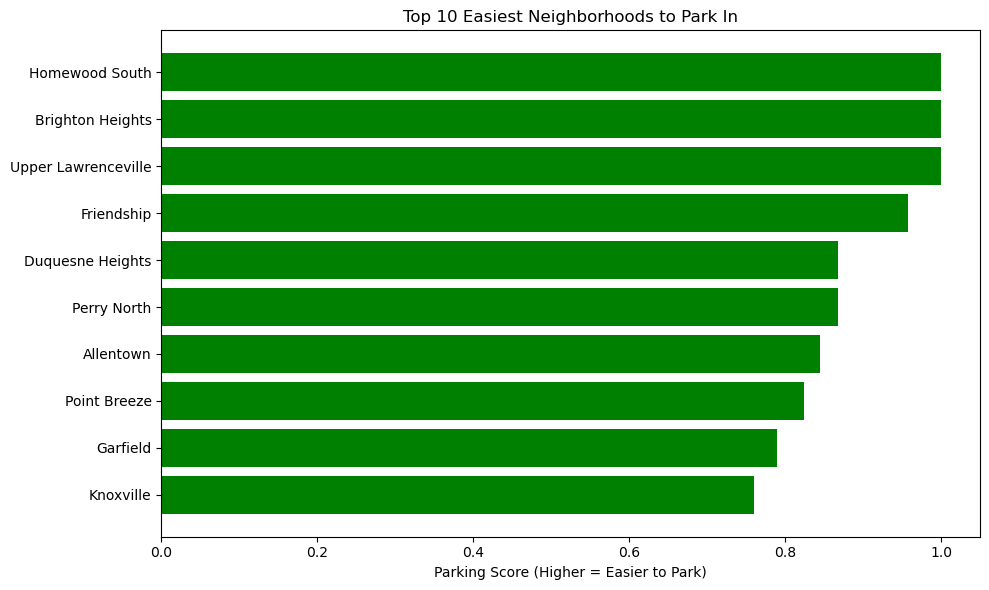

In [40]:
top10 = parking_df.sort_values(by='parking_score', ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.barh(top10['hood'], top10['parking_score'], color='green')
plt.xlabel("Parking Score (Higher = Easier to Park)")
plt.title("Top 10 Easiest Neighborhoods to Park In")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



## Bottom 10 Neighborhoods (Most Painful to Park In)

These are the 10 neighborhoods with the **lowest** parking scores.


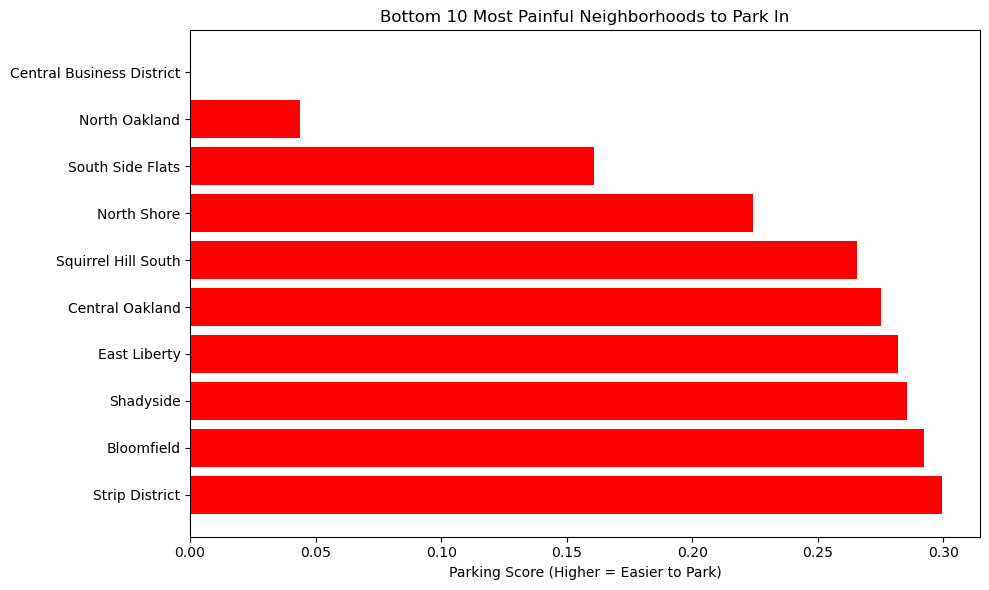

In [43]:
bottom10 = parking_df.sort_values(by='parking_score', ascending=True).head(10)
plt.figure(figsize=(10, 6))
plt.barh(bottom10['hood'], bottom10['parking_score'], color='red')
plt.xlabel("Parking Score (Higher = Easier to Park)")
plt.title("Bottom 10 Most Painful Neighborhoods to Park In")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Reflection

This analysis explored parking difficulty across Pittsburgh’s neighborhoods using two main inputs: 
1. the total number of parking meters, and  
2. the average hourly meter rate.

The idea is straightforward, areas with more meters and higher rates are generally harder or more frustrating to park in. Our initial metric: pain_raw = meter_count x avg_rate, worked conceptually, but the results were tightly clustered since most neighborhoods have very similar hourly rates and meter densities. When these values were normalized to a 0–1 scale, almost every neighborhood ended up with a very similar score, which made the visualization nearly flat and not very helpful.
To fix this issue, I applied a logarithmic transformation to the raw pain scores before normalization. This doesn’t change the order of the neighborhoods or alter the meaning of the metric, it simply spreads out small differences so they’re easier to see. This makes the parking_score more interpretable without adding any complicated weighting or assumptions. The logarithmic transformation I used is pain_log = ln(1 + pain_raw).

### Easiest Neighborhoods to Park In:
Based on the final parking_score, the easiest neighborhoods to park in are:
 - Homewood South
 - Brighton Heights
 - Upper Lawrenceville
 - Friendship
 - Duquesne Heights
These area tend to have very few meters and relatively low average parking rates, which suggest less commercial activity and lower demand for metered parking. As a result, parking there is generally less competitive and less costly.
### Most Difficult Neighborhoods to Park In:
On the opposite end, the neighborhoods with the lowest parking scores (meaning the most difficult parking situations) are:
 - Central Business District
 - North Oakland
 - South Side Flats
 - North Shore
 - Squirrel Hill South

These are some of the busiest and most commercially dense parts of Pittsburgh. They have large numbers of meters, higher hourly prices, or both, which naturally create more competition for parking and higher turnover. The Central Business District stands out the most, it has the highest average parking rate and a heavy concentration of meters, making it the hardest neighborhood to park in according to our metric.

In [46]:
parking_df.to_csv("../data/processed/parking_scores.csv", index=False)